# Classify 3-D Lung Tumor Scans Based on Persistence Images
This will pick up where '3D_complex_generator.ipynb' left off by creating persistence images and running classifiers on them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import gudhi as gd
import pandas as pd
import PersistenceImages.persistence_images as pimg

### Start by loading in the persistent homology data

In [2]:
rad_phom_0s = np.load('C:/Users/Adam/Documents/Datasets/Radiomics_Homology/rad_phom_0s.npy', allow_pickle = True)
rad_phom_1s = np.load('C:/Users/Adam/Documents/Datasets/Radiomics_Homology/rad_phom_1s.npy', allow_pickle = True)
rad_phom_2s = np.load('C:/Users/Adam/Documents/Datasets/Radiomics_Homology/rad_phom_2s.npy', allow_pickle = True)

radg_phom_0s = np.load('C:/Users/Adam/Documents/Datasets/Radiogenomics_Homology/radg_phom_0s.npy', allow_pickle = True)
radg_phom_1s = np.load('C:/Users/Adam/Documents/Datasets/Radiogenomics_Homology/radg_phom_1s.npy', allow_pickle = True)
radg_phom_2s = np.load('C:/Users/Adam/Documents/Datasets/Radiogenomics_Homology/radg_phom_1s.npy', allow_pickle = True)

### Set up persistence image parameters. 

In [3]:
pers_imager = pimg.PersistenceImager()
pers_imager.pixel_size = 0.05
pers_imager.birth_range = (0,1)
pers_imager.pers_range = (0,1)
pers_imager.kernel_params['sigma'][0] = [0.05, 0]
pers_imager.kernel_params['sigma'][1] = [0, 0.05]


print(pers_imager.kernel_params['sigma'][0])
print(pers_imager)

[0.05 0.  ]
PersistenceImager object: 
  pixel size: 0.05 
  resolution: (20, 20) 
  birth range: (0, 1) 
  persistence range: (0, 1) 
  weight: linear_ramp 
  kernel: bvncdf 
  weight parameters: {} 
  kernel parameters: {sigma: [[0.05 0.  ]
 [0.   0.05]]}


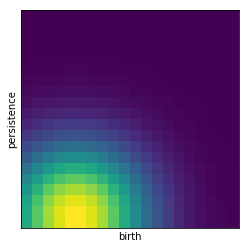

In [4]:
pers_imager.plot_image(rad_phom_0s[190], skew = True)

In [5]:
pers_img_0_test = pers_imager.transform(rad_phom_0s[190], skew=True)
print(pers_img_0_test.shape)

(20, 20)


### Create persistence images from all tumor scans and concatenate arrays

In [6]:
def HomologyToImageVector(phom_0, phom_1, phom_2, imager):
    
    pers_img_0 = imager.transform(phom_0, skew=True)
    pers_img_1 = imager.transform(phom_1, skew=True)
    if len(phom_2) == 0: #Lung 192 is why we can't have nice things
        pers_img_2 = np.zeros_like(pers_img_1)
    else:
        pers_img_2 = imager.transform(phom_2, skew=True)
      
    return(pers_img_0, pers_img_1, pers_img_2)

In [7]:
%%time
#This cell takes ~6min 30s on my machine for pixel size = 0.05, sigma = 0.05
#Much longer if smaller

#Radiomics Dataset

rad_0d_images = []
rad_1d_images = []
rad_2d_images = []
rad_concatenated_images = []

for i in range(len(rad_phom_0s)):
    pimg_0, pimg_1, pimg_2 = HomologyToImageVector(rad_phom_0s[i],rad_phom_1s[i],rad_phom_2s[i], pers_imager)
    
    #Save the original Images
    rad_0d_images.append(pimg_0)
    rad_1d_images.append(pimg_1)
    rad_2d_images.append(pimg_2)
    
    #Resize to allow concatenation
    pimg_0 = np.resize(pimg_0, (1, len(pimg_0)**2))
    pimg_1 = np.resize(pimg_1, (1, len(pimg_1)**2))
    pimg_2 = np.resize(pimg_2, (1, len(pimg_2)**2))
    
    #concatenate
    imgs = np.concatenate((pimg_0[0], pimg_1[0], pimg_2[0]), axis=0)
    rad_concatenated_images.append(imgs)

rad_0d_images = np.array(rad_0d_images)
rad_1d_images = np.array(rad_1d_images)
rad_2d_images = np.array(rad_2d_images)
rad_concatenated_images = np.array(rad_concatenated_images)


#Radiogenomics Dataset

radg_0d_images = []
radg_1d_images = []
radg_2d_images = []
radg_concatenated_images = []

for i in range(len(radg_phom_0s)):
    pimg_0, pimg_1, pimg_2 = HomologyToImageVector(radg_phom_0s[i],radg_phom_1s[i],radg_phom_2s[i], pers_imager)
    
    #Save the original Images
    radg_0d_images.append(pimg_0)
    radg_1d_images.append(pimg_1)
    radg_2d_images.append(pimg_2)
    
    #Resize to allow concatenation
    pimg_0 = np.resize(pimg_0, (1, len(pimg_0)**2))
    pimg_1 = np.resize(pimg_1, (1, len(pimg_1)**2))
    pimg_2 = np.resize(pimg_2, (1, len(pimg_2)**2))
    
    #concatenate
    imgs = np.concatenate((pimg_0[0], pimg_1[0], pimg_2[0]), axis=0)
    radg_concatenated_images.append(imgs)

radg_0d_images = np.array(radg_0d_images)
radg_1d_images = np.array(radg_1d_images)
radg_2d_images = np.array(radg_2d_images)
radg_concatenated_images = np.array(radg_concatenated_images)

Wall time: 6min 31s


### Read in clinical data

In [8]:
#Radiomics clinical data
rad_clinical = pd.read_csv("rad_clinic.csv")
rad_clinical = rad_clinical.drop(rad_clinical.index[127]) #Tumor 128 has no segmentation

rad_histology = rad_clinical.Histology

#Radiogenomics clinical data
radg_clinical = pd.read_csv("radg_clinic.csv", skiprows = range(1,50))
radg_clinical = radg_clinical[0:146]
radg_clinical = radg_clinical.drop(radg_clinical.index[[8, 142]]) #9 and 143 have no segmentation

radg_clinical["Histology"] = radg_clinical['Histology'].str.lower()
radg_histology = radg_clinical.Histology

### Combine Datasets

In [9]:
radg_adeno = radg_histology == 'adenocarcinoma'
radg_squamous = radg_histology == 'squamous cell carcinoma'
rad_adeno = rad_histology == 'adenocarcinoma'
rad_squamous = rad_histology == 'squamous cell carcinoma'

#Select for adenocarcinoma and squamous cell carcinoma only
#Tumor type data
radg_histology_adsq = np.array(radg_histology[radg_adeno | radg_squamous])
rad_histology_adsq = np.array(rad_histology[rad_adeno | rad_squamous])

#Images from individual dimensions
radg_0d_images_adsq = radg_0d_images[radg_adeno | radg_squamous]
rad_0d_images_adsq = rad_0d_images[rad_adeno | rad_squamous]

radg_1d_images_adsq = radg_1d_images[radg_adeno | radg_squamous]
rad_1d_images_adsq = rad_1d_images[rad_adeno | rad_squamous]

radg_2d_images_adsq = radg_2d_images[radg_adeno | radg_squamous]
rad_2d_images_adsq = rad_2d_images[rad_adeno | rad_squamous]

#Concatenated images
radg_concatenated_images_adsq = radg_concatenated_images[radg_adeno | radg_squamous]
rad_concatenated_images_adsq = rad_concatenated_images[rad_adeno | rad_squamous]

#Combine
histology_adsq = np.array(list(radg_histology_adsq) + list(rad_histology_adsq))

images_0d_adsq = np.array(list(radg_0d_images_adsq) + list(rad_0d_images_adsq))
images_1d_adsq = np.array(list(radg_1d_images_adsq) + list(rad_1d_images_adsq))
images_2d_adsq = np.array(list(radg_2d_images_adsq) + list(rad_2d_images_adsq))

images_adsq = np.array(list(radg_concatenated_images_adsq) + list(rad_concatenated_images_adsq))

### Look at some average persistence images

In [10]:
#The PersistenceImages library only has a function to plot the image from the persistence homology
#This function adapts the one in the library to make the same kind of plot from an nxn array
def plot_image_from_image(pers_img):
    ax = plt.gca()
    ax.matshow(pers_img.T, **{'origin': 'lower'})
    
    plt.xlabel('birth')
    plt.ylabel('persistence')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

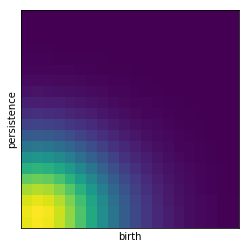

In [11]:
#Calculate average persistence images
avg_2d_adeno_img = np.mean(images_2d_adsq[histology_adsq == 'adenocarcinoma'], axis=0)
plot_image_from_image(avg_2d_adeno_img)

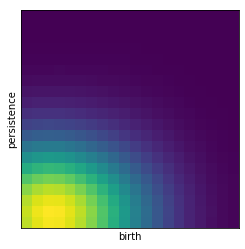

In [12]:
avg_2d_squamous_img = np.mean(images_2d_adsq[histology_adsq == 'squamous cell carcinoma'], axis=0)
plot_image_from_image(avg_2d_squamous_img)

# Classification of tumor types

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from xgboost import XGBClassifier

## XGBoost

### Radiomics Dataset

In [14]:
scores = []
y_pred = []
clf_xgboost = XGBClassifier(scale_pos_weight = 3)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(rad_concatenated_images_adsq):

    X_train, X_test = rad_concatenated_images_adsq[train_index], rad_concatenated_images_adsq[test_index]
    y_train, y_test = rad_histology_adsq[train_index], rad_histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
y_pred = [val for sublist in y_pred for val in sublist]

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(rad_histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 67.50%
[[  8  43]
 [ 23 129]]


### Radiogenomics Dataset

In [15]:
scores = []
y_pred = []

clf_xgboost = XGBClassifier(scale_pos_weight = 3)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(radg_concatenated_images_adsq):

    X_train, X_test = radg_concatenated_images_adsq[train_index], radg_concatenated_images_adsq[test_index]
    y_train, y_test = radg_histology_adsq[train_index], radg_histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
y_pred = [val for sublist in y_pred for val in sublist]

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(radg_histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 67.41%
[[93 19]
 [27  2]]


### XGBoost

In [16]:
%%time

#First we need to shuffle this dataset since otherwise k-fold will magnify batch effects.
images_adsq, histology_adsq = shuffle(images_adsq, histology_adsq, random_state = 10)

scores = []
y_pred = []
clf_xgboost = XGBClassifier()
cv = KFold(n_splits=5, shuffle=False)
for train_index, test_index in cv.split(images_adsq):

    X_train, X_test = images_adsq[train_index], images_adsq[test_index]
    y_train, y_test = histology_adsq[train_index], histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
    
y_pred = [val for sublist in y_pred for val in sublist]    
print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 63.38%
[[ 99  64]
 [ 62 119]]
Wall time: 3.89 s


### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [18]:
%%time

#First we need to shuffle this dataset since otherwise k-fold will magnify batch effects.
images_adsq, histology_adsq = shuffle(images_adsq, histology_adsq, random_state = 10)

scores = []
y_pred = []


clf_logreg = LogisticRegression(penalty = 'l1', solver='liblinear')


cv = KFold(n_splits=5, shuffle=False)
for train_index, test_index in cv.split(images_adsq):

    X_train, X_test = images_adsq[train_index], images_adsq[test_index]
    y_train, y_test = histology_adsq[train_index], histology_adsq[test_index]
    clf_logreg.fit(X_train, y_train)
    y_pred.append(list(clf_logreg.predict(X_test)))
    scores.append(clf_logreg.score(X_test, y_test))
    
y_pred = [val for sublist in y_pred for val in sublist]    

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 73.54%
[[115  48]
 [ 43 138]]
Wall time: 235 ms
